In [1]:
from ROOT import TMVA, TFile, TTree, TCut
from subprocess import call
from os.path import isfile
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.optimizers import Adam


Welcome to JupyROOT 6.19/01


Using TensorFlow backend.


In [2]:
TMVA.Tools.Instance();
TMVA.PyMethodBase.PyInitialize();
sigFile = TFile.Open("./ttHiggs0PToGG.root")
bkgFile=TFile.Open("./ttHiggs0MToGG.root");
outfileName="keras_DNN.root";
outputFile = TFile.Open(outfileName, "RECREATE");
factory = TMVA.Factory("TMVAClassification", outputFile,
                      "!V:ROC:!Correlations:!Silent:Color:!DrawProgressBar:AnalysisType=Classification" );

In [3]:
delta_phi_pho="delta_phi_pho:=(abs(pho1_phi-pho2_phi))*(abs(pho1_phi-pho2_phi)<3.14)+\
(2*3.14-abs(pho1_phi-pho2_phi))*(abs(pho1_phi-pho2_phi)>3.14)";
delta_phi_jet="delta_phi_jet:=(abs(jetPhi_1-jetPhi_2))*(abs(jetPhi_1-jetPhi_2)<3.14)+\
(2*3.14-abs(jetPhi_1-jetPhi_2))*(abs(jetPhi_1-jetPhi_2)>3.14)";
delta_phi_bjet="delta_phi_jet:=(abs(bjetPhi_1-bjetPhi_2))*(abs(bjetPhi_1-bjetPhi_2)<3.14)+\
(2*3.14-abs(bjetPhi_1-bjetPhi_2))*(abs(bjetPhi_1-bjetPhi_2)>3.14)";

In [4]:
loader=TMVA.DataLoader("kera_dataset");
'''
loader.AddVariable("delta_phoj_eta:=pho1_eta-jetEta_1",'F');
loader.AddVariable("delta_phoj_phi:=pho1_phi-jetPhi_1",'F');
loader.AddVariable("delata_jj_eta:=jetEta_1-jetEta_2",'F');
loader.AddVariable("delta_pho_eta:=pho1_eta-pho2_eta",'F');
loader.AddVariable(delta_phi_pho,"delta_phi_pho","",'F');
loader.AddVariable(delta_phi_jet,"delta_phi_jet","",'F');
loader.AddVariable("diPhoPt",'F');
loader.AddVariable("diPhoEta",'F');
loader.AddVariable(delta_phi_bjet,'F');
loader.AddVariable("top1_tt_costheta",'F'); 
'''

'\nloader.AddVariable("delta_phoj_eta:=pho1_eta-jetEta_1",\'F\');\nloader.AddVariable("delta_phoj_phi:=pho1_phi-jetPhi_1",\'F\');\nloader.AddVariable("delata_jj_eta:=jetEta_1-jetEta_2",\'F\');\nloader.AddVariable("delta_pho_eta:=pho1_eta-pho2_eta",\'F\');\nloader.AddVariable(delta_phi_pho,"delta_phi_pho","",\'F\');\nloader.AddVariable(delta_phi_jet,"delta_phi_jet","",\'F\');\nloader.AddVariable("diPhoPt",\'F\');\nloader.AddVariable("diPhoEta",\'F\');\nloader.AddVariable(delta_phi_bjet,\'F\');\nloader.AddVariable("top1_tt_costheta",\'F\'); \n'

In [5]:
loader.AddVariable("top1_phi",'F');
loader.AddVariable("top1_eta",'F');
loader.AddVariable("top1_pt",'F');
loader.AddVariable("top1_m",'F' );
loader.AddVariable("top2_phi",'F');
loader.AddVariable("top2_eta",'F'); 
loader.AddVariable("top2_pt",'F');
loader.AddVariable("top2_m",'F' );
loader.AddVariable("bjetPt_1",'F');
loader.AddVariable("bjetE_1",'F');
loader.AddVariable("bjetPhi_1",'F');
loader.AddVariable("bjetEta_1",'F');
loader.AddVariable("bjetEta_2",'F');
loader.AddVariable("helcosthetaZ1_3",'F');
loader.AddVariable("helcosthetaZ1_4",'F');
loader.AddVariable("helcosthetaZ2_1",'F');
loader.AddVariable("helcosthetaZ2_3",'F');
loader.AddVariable("costhetastar_1",'F');
loader.AddVariable("costhetastar_3",'F');
loader.AddVariable("costhetastar_4",'F');
loader.AddVariable("helphi_3",'F');
loader.AddVariable("phistarZ1_3",'F');
loader.AddVariable("phistarZ1_4",'F');
loader.AddVariable("phistarZ2_1",'F');
loader.AddVariable("phistarZ2_3",'F');
loader.AddVariable("top1_tt_costheta",'F'); 


In [6]:

pho_vars=["pt","eta","phi"]
for ipho in range(1,3):
    for ivar in pho_vars:
        var="pho"+str(ipho) +"_"+ivar
        loader.AddVariable(var,'F')
jet_vars=["Pt","Eta","Phi","E"]
for ijet in range(1,7):
    btag="btag_"+str(ijet)
    loader.AddVariable(btag,'F')
    for ivar in jet_vars:
        jetvar="jet"+ivar+"_"+str(ijet)
        loader.AddVariable(jetvar,'F')


In [7]:
tsignal=sigFile.Get("ttH_0P_125_13TeV_TTHHadronicTag")
tbackground=bkgFile.Get("ttH_0M_125_13TeV_TTHHadronicTag")
mycuts="tthMvaRes>0.38 && pho1_idmva>-0.2 && pho2_idmva >-0.2";
mycutb="tthMvaRes>0.38 && pho1_idmva>-0.2 && pho2_idmva >-0.2";


loader.AddSignalTree    (tsignal,     1.0);   
loader.AddBackgroundTree(tbackground, 1.0);   

loader.SetBackgroundWeightExpression( "weight" );
loader.SetSignalWeightExpression("weight");
loader.PrepareTrainingAndTestTree(TCut(mycuts), TCut(mycutb),
                                   "nTrain_Signal=0:nTrain_Background=0:SplitMode=Random:NormMode=NumEvents:!V" );

DataSetInfo              : [kera_dataset] : Added class "Signal"
                         : Add Tree ttH_0P_125_13TeV_TTHHadronicTag of type Signal with 67263 events
DataSetInfo              : [kera_dataset] : Added class "Background"
                         : Add Tree ttH_0M_125_13TeV_TTHHadronicTag of type Background with 84499 events


In [8]:
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=62))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer="adam", metrics=['accuracy', ])

model.save("model.hn")

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                2016      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 66        
Total params: 4,194
Trainable params: 4,194
Non-trainable params: 0
_________________________________________________________________


2019-07-06 15:52:18.560673: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2019-07-06 15:52:18.582066: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 1992000000 Hz
2019-07-06 15:52:18.582665: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x5564b7122160 executing computations on platform Host. Devices:
2019-07-06 15:52:18.582686: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>


In [9]:
factory.BookMethod(loader, TMVA.Types.kFisher, 'Fisher',
                   '!H:!V:Fisher:VarTransform=D,G');
factory.BookMethod(loader, TMVA.Types.kBDT, 'BDT',
                   '!H:!V:NTrees=500:MaxDepth=3:BoostType=AdaBoost:nCuts=20');
factory.BookMethod(loader, TMVA.Types.kPyKeras, 'PyKeras',
                   'H:!V:VarTransform=N:FilenameModel=model.hn:NumEpochs=40:BatchSize=512');
factory.TrainAllMethods();
factory.TestAllMethods();
factory.EvaluateAllMethods();


Instructions for updating:
Use tf.cast instead.
Train on 53694 samples, validate on 13423 samples
Epoch 1/40
53694/53694 [==============================] - 0s 9us/step - loss: 0.6857 - acc: 0.5574 - val_loss: 0.6781 - val_acc: 0.5654

Epoch 00001: val_loss improved from inf to 0.67809, saving model to kera_dataset/weights/TrainedModel_PyKeras.h5
Epoch 2/40
53694/53694 [==============================] - 0s 4us/step - loss: 0.6761 - acc: 0.5714 - val_loss: 0.6688 - val_acc: 0.5812

Epoch 00002: val_loss improved from 0.67809 to 0.66880, saving model to kera_dataset/weights/TrainedModel_PyKeras.h5
Epoch 3/40
53694/53694 [==============================] - 0s 4us/step - loss: 0.6642 - acc: 0.5942 - val_loss: 0.6569 - val_acc: 0.6006

Epoch 00003: val_loss improved from 0.66880 to 0.65692, saving model to kera_dataset/weights/TrainedModel_PyKeras.h5
Epoch 4/40
53694/53694 [==============================] - 0s 5us/step - loss: 0.6529 - acc: 0.6124 - val_loss: 0.6505 - val_acc: 0.6119

Epoch 0

53694/53694 [==============================] - 0s 6us/step - loss: 0.5967 - acc: 0.6759 - val_loss: 0.6412 - val_acc: 0.6389

Epoch 00039: val_loss did not improve from 0.63306
Epoch 40/40
53694/53694 [==============================] - 0s 5us/step - loss: 0.5975 - acc: 0.6745 - val_loss: 0.6451 - val_acc: 0.6306

Epoch 00040: val_loss did not improve from 0.63306
Factory                  : Booking method: Fisher
                         : 
Fisher                   : [kera_dataset] : Create Transformation "D" with events from all classes.
                         : 
                         : Transformation, Variable selection : 
                         : Input : variable 'top1_phi' <---> Output : variable 'top1_phi'
                         : Input : variable 'top1_eta' <---> Output : variable 'top1_eta'
                         : Input : variable 'top1_pt' <---> Output : variable 'top1_pt'
                         : Input : variable 'top1_m' <---> Output : variable 'top1_m'
         

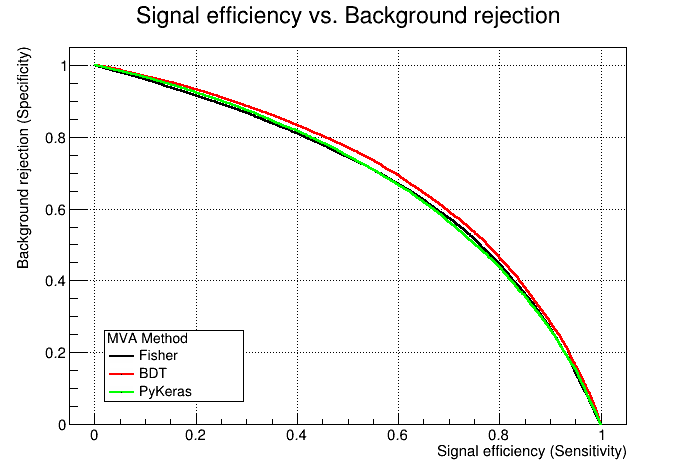

In [10]:
canvas = factory.GetROCCurve(loader)
canvas.Draw()